In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import os,sys
import scipy.io as sc
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.layers.experimental import preprocessing
import time
from IPython.display import clear_output
import math
def dataset(dataFile, labelFile):
    dataFile = "../ML_Symbol_Gen-main/" + dataFile
    labelFile = "../ML_Symbol_Gen-main/" + labelFile
    my_data = sc.loadmat(dataFile)
    my_labels = sc.loadmat(labelFile)
    my_data = my_data['Y']
    X = my_labels['L_S_x']
    myOrig = table_data(my_data, my_labels['L_Constellations'][0], X)
    mytable = assign_label(myOrig)
    return mytable


def assign_label(data):
    c_4 = [1,-1]
    c_16 = [3,1,-1,-3]
    c_16r = [-3,-1,1,3]
    cons_4 = np.dot(np.sqrt(0.5),[complex(i,j)for i in c_4 for j in c_4])
    cons_16 = np.array([complex(i,j)for j in c_16 for i in c_16r])
    cons_16 = cons_16/np.sqrt(np.mean(np.abs(cons_16)**2))
    cons4 = data[data.cons==1]
    cons4_label = np.array([[cons_4[i-1]]for i in cons4.label])
    cons16 = data[data.cons==2]
    cons16_label = np.array([[cons_16[i-1]]for i in cons16.label.to_numpy().real.astype(int)])
    data[data.cons==2].index
    data['buffer'] = 0
    data['buffer'] = 0
    data.iloc[data[data.cons==1].index, 5] = cons4_label
    data.iloc[data[data.cons==2].index, 5] = cons16_label
    data['label_real'] = data.buffer.to_numpy().real
    data['label_imag'] = data.buffer.to_numpy().imag
    myTest = data.copy()
    myTest.loc[myTest.cons == 2, 'label'] = myTest.loc[myTest.cons == 2, 'label'] + 4
    myTest.label = myTest.label - 1
    return myTest


def table_data(my_data, cons, label):
    block = my_data.shape[1]
    my_data_size = my_data.shape[0] * block
    my_data_div = my_data.T.reshape(my_data_size, )
    cons_array = np.array([[cons[i]] * my_data.shape[0] for i in range(0, block)]).reshape(my_data_size, )
    block_array = np.array([([i + 1] * my_data.shape[0]) for i in range(0, block)]).reshape(my_data_size, )
    label_array = label.T.reshape(my_data_size, )
    test_pd = pd.DataFrame({'real': my_data_div.real, 'imag': my_data_div.imag,
                            'cons': cons_array, 'block': block_array,
                            'label': label_array})
    return test_pd

def make_generator():
    model = tf.keras.Sequential()
    model.add(layers.Dense(128, use_bias=False, input_shape=[50,2]))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(2))
    return model


def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(20, use_bias=False, input_shape=[50,2]))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(128, activation = 'sigmoid'))
    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    return model

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def identity_loss(real, fake):
    loss = tf.reduce_mean(tf.abs(real - fake))
    return LAMBDA * 0.5 * loss


@tf.function
def train_step(total, label):
    with tf.GradientTape(persistent=True) as tape:
        s = generator_s(total, training=True)
        n = generator_n(total, training=True)
        i = generator_i(total, training=True)
        gen = (s + n + i)
        gen = tf.reshape(gen, (1,50,2))
        fake_t = discriminator_t(gen, training=True)
        real_t = discriminator_t(total, training=True)
        gen_loss = generator_loss(gen)
        fake_d = discriminator_d(s, training=True)
        real_d = discriminator_d(label, training=True)
        disc_t_loss = discriminator_loss(real_t, fake_t)
        disc_d_loss = discriminator_loss(real_d, fake_d)
        identity_s_loss = identity_loss(label, s)
        identity_g_loss = identity_loss(total, gen)
        total_s_loss = 0.2*(gen_loss+identity_g_loss) + 0.8*(identity_s_loss)
        total_n_loss = identity_g_loss + gen_loss
        total_i_loss = identity_g_loss + gen_loss

    gradients_of_s_generator = tape.gradient(total_s_loss, generator_s.trainable_variables)
    gradients_of_i_generator = tape.gradient(total_i_loss, generator_i.trainable_variables)
    gradients_of_n_generator = tape.gradient(total_n_loss, generator_n.trainable_variables)
    gradients_of_discriminator_t = tape.gradient(disc_t_loss, discriminator_t.trainable_variables)
    gradients_of_discriminator_d = tape.gradient(disc_d_loss, discriminator_d.trainable_variables)
    generator_s_optimizer.apply_gradients(zip(gradients_of_s_generator, generator_s.trainable_variables))
    generator_i_optimizer.apply_gradients(zip(gradients_of_i_generator, generator_i.trainable_variables))
    generator_n_optimizer.apply_gradients(zip(gradients_of_n_generator, generator_n.trainable_variables))
    discriminator_t_optimizer.apply_gradients(zip(gradients_of_discriminator_t, discriminator_t.trainable_variables))
    discriminator_d_optimizer.apply_gradients(zip(gradients_of_discriminator_d, discriminator_d.trainable_variables))

def shuffle_data(my_table):
    real_y = (2*my_table.real.min())/(my_table.real.max() - my_table.real.min()) + 1
    real_x = (my_table.real.max()) / (1 + real_y)
    imag_y = (2*my_table.imag.min())/(my_table.imag.max() - my_table.imag.min()) + 1
    imag_x = (my_table.imag.max()) / (1 + imag_y)
    my_table.real = (my_table.real / real_x) - real_y
    my_table.imag = (my_table.imag/ imag_x) - imag_y
    train_feature = data.loc[:, ('real', 'imag')]
    train_label = data.loc[:, ('label_real', 'label_imag')]
    test_feature = tf.cast(train_feature, tf.float32)
    test_label = tf.cast(train_label, tf.float32)
    test_feature = tf.reshape(test_feature,(1000,1,50,2))
    test_label = tf.reshape(test_label, (1000,1,50,2))
    symbol = data.loc[:, 'label']
    return test_feature, test_label

generator_s = make_generator()
generator_n = make_generator()
generator_i = make_generator()
discriminator_t = make_discriminator_model()
discriminator_d = make_discriminator_model()


generator_s_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_n_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_i_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_d_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_t_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

checkpoint_path = "./checkpoints/test7"

ckpt = tf.train.Checkpoint(generator_s=generator_s,
                           generator_n=generator_n,
                           generator_i=generator_i,
                           discriminator_t=discriminator_t,
                           discriminator_d=discriminator_d,
                           generator_s_optimizer=generator_s_optimizer,
                           generator_n_optimizer=generator_n_optimizer,
                           generator_i_optimizer=generator_i_optimizer,
                           discriminator_d_optimizer=discriminator_d_optimizer,
                           discriminator_t_optimizer=discriminator_t_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

LAMBDA = 10
EPOCHS = 40
data1 = "my_data"
data1_label = "my_labels"
data = dataset(data1, data1_label)
file_directory = './result/tes2/'
f, l = shuffle_data(data)

Latest checkpoint restored!!


In [5]:
s = generator_s(f_t, training=False)
i = generator_i(f_t, training=False)
n = generator_n(f_t, training=False)
gen = s + i + n

In [3]:
data1 = "my_data1"
data1_label = "my_labels1"
data2 = dataset(data1, data1_label)

In [4]:
f_t, l_t = shuffle_data(data2)

In [7]:
identity_loss(f_t, gen)

<tf.Tensor: shape=(), dtype=float32, numpy=0.11163777>

In [8]:
identity_loss(l_t, s)

<tf.Tensor: shape=(), dtype=float32, numpy=0.76456225>

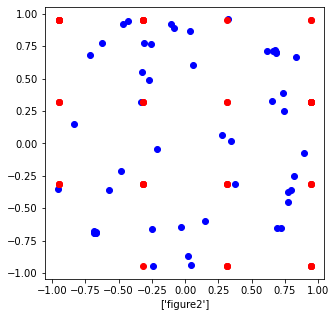

In [55]:
fig, ax2 = plt.subplots(1, figsize=(5,5))
ax2.plot(real_s, imag_s, 'o', color='blue')
ax2.plot(r_l, i_l,'o', color='red')
ax2.set_xlabel(["figure2"])
plt.savefig("./result/test2.png", dpi=500)

In [43]:
real_s = s[0].numpy().reshape(50,2)[:,0]
imag_s = s[0].numpy().reshape(50,2)[:,1]

In [42]:
r_l = l[0].numpy().reshape(50,2)[:,0]
i_l = l[0].numpy().reshape(50,2)[:,1]

In [56]:
r_l - real_s

array([ 0.03750256,  0.01243952,  0.9059503 ,  0.57147634, -0.40261385,
       -0.3789345 ,  0.17233753, -0.02970526, -0.0430924 , -0.35476577,
        1.1924298 ,  0.17633176, -0.63838136, -0.84447384, -0.00755689,
        0.99907434,  0.21537387,  0.00931084,  0.05675125, -0.99074364,
        0.29447424, -1.6332963 , -1.6303715 , -0.4673633 ,  0.20740461,
       -0.98084855,  0.9966636 ,  1.2008914 , -0.10808235, -0.69108456,
        0.11315227,  0.12651372, -0.5159565 ,  0.9966295 ,  0.254647  ,
        0.15536094, -0.2306546 , -0.47923362, -0.28829527,  0.29528868,
       -0.1152997 ,  0.1642727 ,  1.0008414 , -0.93290806,  0.00716791,
        0.26035976, -0.86560225,  1.6209179 , -0.32574922,  1.6198734 ],
      dtype=float32)

In [57]:
r_l

array([ 0.31622776, -0.31622776,  0.9486833 ,  0.9486833 ,  0.31622776,
       -0.31622776,  0.9486833 ,  0.31622776, -0.31622776, -0.31622776,
        0.9486833 ,  0.9486833 , -0.9486833 , -0.9486833 ,  0.31622776,
        0.31622776,  0.9486833 , -0.9486833 ,  0.9486833 , -0.31622776,
        0.31622776, -0.9486833 , -0.9486833 , -0.31622776,  0.9486833 ,
       -0.31622776,  0.31622776,  0.9486833 , -0.31622776, -0.9486833 ,
        0.9486833 ,  0.9486833 , -0.9486833 ,  0.31622776, -0.31622776,
        0.9486833 , -0.9486833 , -0.9486833 , -0.31622776,  0.9486833 ,
       -0.9486833 , -0.31622776,  0.31622776, -0.31622776, -0.31622776,
        0.9486833 , -0.9486833 ,  0.9486833 , -0.9486833 ,  0.9486833 ],
      dtype=float32)

In [58]:
real_s

array([ 0.2787252 , -0.32866728,  0.042733  ,  0.37720698,  0.7188416 ,
        0.06270675,  0.7763458 ,  0.34593302, -0.27313536,  0.03853802,
       -0.24374647,  0.77235156, -0.310302  , -0.1042095 ,  0.32378465,
       -0.68284655,  0.73330945, -0.95799416,  0.8919321 ,  0.67451584,
        0.0217535 ,  0.684613  ,  0.68168813,  0.15113555,  0.7412787 ,
        0.6646208 , -0.6804358 , -0.25220805, -0.20814541, -0.25759876,
        0.83553106,  0.8221696 , -0.4327268 , -0.68040174, -0.57087475,
        0.7933224 , -0.7180287 , -0.4694497 , -0.02793248,  0.65339464,
       -0.8333836 , -0.48050046, -0.6846136 ,  0.6166803 , -0.32339567,
        0.68832356, -0.08308108, -0.6722346 , -0.6229341 , -0.6711901 ],
      dtype=float32)

In [1]:
import tensorflow as tf

In [4]:
x = tf.constant([[1., 2.], [2., 2.]])
tf.reduce_mean(x)

<tf.Tensor: shape=(), dtype=float32, numpy=1.75>

In [5]:
7/4

1.75